# Lab 7: Generative models. Generating doodles with VAE.

In this lab, we will get familiar with the architecture of Variational Autoencoders (VAEs) and train a VAE to generate doodles (hand-drawn images) by training it on the Quick, Draw! dataset. [Quick, Draw!](https://quickdraw.withgoogle.com/) is a game developed by Google, where players are asked to draw a specific object in under 20 seconds. The game collects the drawings and makes them available as a dataset for machine learning research. The dataset consists of 345 categories of objects, each with 70,000 images. We will use a subset of the dataset with only 3 categories of images: **umbrella**, **butterfly** and **mug**.

---

Autoencoders are a type of neural networks which, given an input $x$, learn to output $x$ itself. Why would we want a deep neural network to learn the identity function? The answer is - that is not the main goal at all.

The autoencoder architecture is designed in such a way that in order to execute this simple task, the network has to **compress** the input data into a **latent space** of lower dimensionality, and then **reconstruct** the input data from this compressed representation. This low-dimensional representation $z$ of data $x$ is learned in an unsupervised manner, meaning that the network is not given any labels or targets, but it **learns to represent the data in a way that makes the task of reconstruction easier.**

**Although the objective is to learn such a latent representation that is useful for reconstructing the input data, the latent space of an AE model can be thought of as an automatic feature extractor.** Latent representations of input data can be used for other tasks, such as classification or clustering, or for generating new data that is similar to the input data.

<center>
<img src="imgs/autoencoders.png" width="500">
</center>
<br>

**The idea behind autoencoders is as follows:** the encoder (a neural network) compresses the input data $x$ into a latent representation $z$, and the decoder (also a neural network) takes $z$ and tries to generate such an output $\hat{x}$, that it is as close to $x$ as possible. The loss function used for training AEs is the difference between the input and the output, which is called the **reconstruction loss**.

**Variational Autoencoders (VAEs)** are a type of autoencoder that is trained to learn a probabilistic latent space. Instead of learning a single point $z$ in the latent space, the VAE learns a distribution $p(z|x)$. This distribution is learned in such a way that it is close to a standard normal distribution $\mathcal{N}(0, 1)$, and the network is penalized if the learned distribution deviates from the standard normal distribution. This makes the latent space of a VAE **continuous**, and guarantees that if we sample a point from the standard normal distribution and pass it through the decoder, we will get some meaningful output. This is a pinnacle feature of VAEs, as it allows us to **generate new data** by sampling from the latent space and passing the samples through the decoder, which makes VAE a **generative model.**

To get the distribution $p(z|x)$, the VAE encoder outputs two vectors: the mean $\mu$ and the log variance $\log \sigma^2$. The latent vector $z$ is then sampled from the distribution $\mathcal{N}(\mu, \sigma^2)$ using the formula:

$$ z = \mu + \sigma \odot \epsilon $$

where $\epsilon$ is a random sample from the standard normal distribution $\mathcal{N}(0, 1)$.
This is known as the **reparametrization trick**, and it is differentiable, which allows us to train the VAE with backpropagation. As you can see, again and again, differentiability is a big deal in deep learning.

### Before we implement an autoencoder, let's take a look at our training data:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [2]:
train = pd.read_csv('data/doodles-train.csv')
train_X = np.array(train.drop('label', axis=1))
train_y = np.array(train['label'])

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")

train_X shape: (27000, 784)
train_y shape: (27000,)


This is a butterfly:


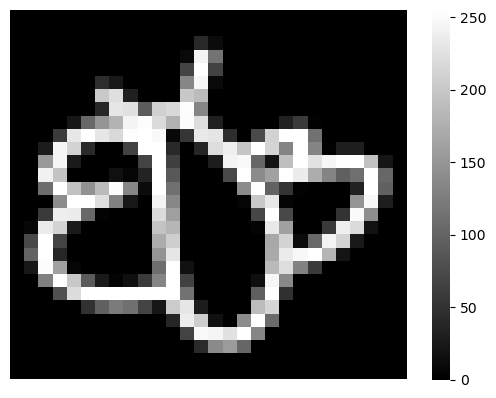

In [3]:
train_X_reshaped = train_X.reshape(-1, 28, 28)  # reshape to 28x28, which is the size of a single image

i = 0   # see the i-th image in the training set

# plot the i-th image
import seaborn as sns
sns.heatmap(train_X_reshaped[i], cmap='gray', xticklabels=False, yticklabels=False)
print(f"This is a {train_y[i]}:" if train_y[i] != "umbrella" else "This is an umbrella:")

## Autoencoder in PyTorch

An example of how an autoencoder (not a variational one) can be implemented in PyTorch is shown below. The encoder and decoder are simple feedforward neural networks with one hidden layer, which take an input of size 256 and compress it to a latent space of size 16.

```python
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, latent_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):   # for the decoder, we can use the same architecture as the encoder, but in reverse
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc3 = nn.Linear(128, 784)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_size)  # initialize the encoder with the given latent size
        self.decoder = Decoder(latent_size)  # initialize the decoder with the same latent size

    def forward(self, x):
        z = self.encoder(x)         # compress the input into the latent space
        x_hat = self.decoder(z)     # reconstruct the input from the latent space
        return x_hat
```

## Excercise 1: Implement VAE architecture (3 points)

Implement a VAE architecture in PyTorch as `VAE` class. The architecture should consist of an encoder and a decoder, both with two hidden layers. The size of the latent space should be set in the constructor of the `VAE` class.

The encoder should output the mean and the log variance of the learned distribution as vectors. The `VAE` class should have a `reparametrize` method, which takes the mean and the log variance as input and return a latent vector $z$.
$$ \sigma = \exp(0.5*\log \sigma^2) $$
$$ z = \mu + \sigma \odot \epsilon $$

where $\mu$ is the mean vector, $\sigma$ is the log variance vector, and $\epsilon$ is a random sample from the standard normal distribution. Note that the size of $\mu$ and $\sigma$  should be the same as the size of the latent vector $z$.

Epsilon vector can be generated with a torch function:
    
    epsilon = torch.randn_like(mu)  # make a random tensor of the same size as mu

The latent vector $z$ should be passed to the decoder, which should output the reconstructed image.



In [21]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_size):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, latent_size)
        self.fc_logvar = nn.Linear(64, latent_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 784)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

class VAE(nn.Module):
    def __init__(self, latent_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar
    
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std # reparametrization trick!

## Kullback-Leibler divergence (KL divergence)

The Kullback-Leibler divergence (KL divergence) is a measure of similarity between two probability distributions $p$ and $q$. It is defined as:

$$ \text{KL}(p || q) = \sum_{x} p(x) \log \frac{p(x)}{q(x)} $$

where $p(x)$ and $q(x)$ are the probabilities of the event $x$ under the distributions $p$ and $q$, respectively.


In [5]:
# Let's see an example of two normal distributions and their KL divergence

import numpy as np
import pandas as pd
import seaborn as sns

def gaussian(x, mu=0, var=1):
    # normal distribution with mean mu and variance var
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(-(x - mu)**2 / (2 * var))


X = np.linspace(-4, 4, 100) # x values
p = gaussian(X, mu=0, var=1) # p(x) ~ N(0, 1), standard normal distribution

KL divergence = 14.27


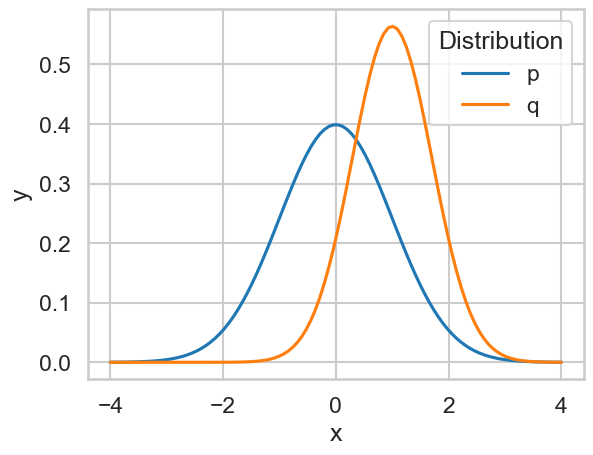

In [6]:
# Choose a different mean and variance for q(x)

mean = 1
variance = 0.5

q = gaussian(X, mu=mean, var=variance) # q(x) ~ N(1, 2)

# Plot the two distributions

plot_df = pd.DataFrame({'x': X, 'p': p, 'q': q})
plot_df = plot_df.melt(id_vars='x', var_name='Distribution', value_name='y')

sns.set_style('whitegrid')
sns.set_context('talk')
sns.lineplot(x='x', y='y', hue='Distribution', data=plot_df)

# Calculate the KL divergence

kl = np.sum(p * np.log(p / q))
print(f"KL divergence = {round(kl, 2)}")

## KL implementation for training VAEs

Kullback-Leibler divergence is also known as the **relative entropy** between two distributions. If you remember the concept of entropy from our 2nd labs, can see that:

$$ \text{KL}(p || q) = \sum_{x} p(x) \log \frac{p(x)}{q(x)} $$
$$ = \sum_{x} p(x) \log p(x) - \sum_{x} p(x) \log q(x) $$
$$ = H(p, q) - H(p)$$

So, the KL divergence is the difference between the entropy of $p$ and the cross-entropy of $p$ and $q$. In the case of VAEs, the q distribution is the learned distribution of the latent variables, and the p distribution is the standard normal distribution $\mathcal{N}(0, 1)$. If we assume that the learned distribution is also a normal distribution $\mathcal{N}(\mu, \sigma^2)$, the KL divergence can be calculated in the closed form, which is easy to implement in PyTorch:

$$ KL(p || q) = -\frac{1}{2} \sum_{i=1}^n (1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2) $$

where $\mu_i$ and $\sigma_i^2$ are the mean and variance of the learned distribution on the $i$-th dimension.

## VAE loss function

The loss function of a VAE consists of two terms: the reconstruction loss and the KL divergence loss. The **reconstruction loss** is binary cross-entropy loss between the output $\hat{x}$ and the input $x$ of the decoder and measures how well our model is able to reconstruct input data. **A visual clue of why binary cross-entropy loss is used to compare the input and output images is presented below (the square represents a single pixel of an image).**

<center>
<img src="imgs/reconstruction-loss.png" width="600">

---

<img src="imgs/bce-loss.png" width="400">
<br>
</center>

The **KL divergence loss** is the Kullback-Leibler divergence between the learned latent distribution and the prior distribution (usually a standard normal distribution $\mathcal{N}(0, 1)$). **The KL divergence loss is used to regularize the latent space and counteract the tendency of the model to learn sparse latent representations that do not generalize well.**

$$ \mathcal{L} = \mathcal{L}_{\text{recon}} + \mathcal{L}_{\text{KL}} $$
$$ \mathcal{L} = BCE(\hat{x}, x) -\frac{1}{2} \sum_{i=1}^n (1 + \log \sigma_i^2 - \mu_i^2 - \sigma_i^2) $$

### By the way... 
**Why do we train the VAE encoder to output log variance instead of plain variance or standard deviation?**

- **Variance** is always positive, so the model would have to learn to output a positive number. This is not a problem, but it is easier to learn to output a number in the range $(-\infty, \infty)$ than in the range $(0, \infty)$.
-  **Log variance** is already needed in the KL divergence formula, so it is more convenient to output it directly. We can get standard deviation simply by exponentiating the log variance: $\sigma = \exp(0.5*\log \sigma^2)$.

It is not like you cannot code a VAE with standard deviation instead of log variance. No one is going to stop you, and it may even work!

## Exercise 2: Implement the VAE loss function (2 points)

Implement the VAE loss function $\mathcal{L}$ in `torch`. It should be written as a class that inherits from `nn.Module`. In the `forward` method, is should take the input $x$, the output $\hat{x}$, the mean $\mu$, and the standard deviation $\sigma$ as arguments and return the loss value as a tensor. The reconstruction loss $\mathcal{L}_{recon}$ should be binary cross-entropy loss between $\hat{x}$ and $x$, and the KL divergence loss $\mathcal{L}_{KL}$ should be calculated as described above.

Binary cross-entropy loss can be calculated with the `BCELoss` class from `torch.nn`. The formula for KL divergence loss is provided above.

In [7]:
import torch.nn as nn

class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.binary_cross_entropy = nn.BCELoss(reduction='sum')

    def forward(self, x_hat, x, mu, sigma):
        # calculate the reconstruction loss
        recon_loss = self.binary_cross_entropy(x_hat, x)

        # calculate the KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + sigma - mu ** 2 - sigma.exp())

        return recon_loss + kl_loss

## Exercise 3: Train the VAE (3 points)

Now, let's train the VAE on the doodles dataset. The training loop is similar to the one we used in the previous labs.

1. Prepare the dataloaders for training and testing, just like in the previous labs.
2. Initialize the VAE model, the optimizer, and the loss function you just implemented.
3. Train the model for a number of epochs. For each epoch, iterate over the training dataloader, calculate the loss, and perform backpropagation, as usual.
4. After each epoch, calculate the loss on the test set and log it to wandb. You can also log the reconstructed images for a few test samples (see [wandb guide](https://docs.wandb.ai/guides/track/log/media/) for logging images) to see how the quality of the reconstructions changes during training.
5. Save the weights of the trained model to a file.

In [19]:
train = pd.read_csv('data/doodles-train.csv')
test = pd.read_csv('data/doodles-test.csv')

mapping = {
    'mug': 0,
    'umbrella': 1,
    'butterfly': 2
}   # encoding scheme for the labels

Y_train = train['label']
X_train = train.drop('label', axis=1)

Y_test = test['label']
X_test = test.drop('label', axis=1)

#print(X_train.shape, Y_train.shape)

y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(Y_test)

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

X_train_std = X_train/255
X_test_std = X_test/255

X_train_t = torch.tensor(X_train_std.to_numpy(), dtype=torch.float32)
Y_train_t = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

X_test_t = torch.tensor(X_test_std.to_numpy(), dtype=torch.float32)
Y_test_t = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

train = TensorDataset(X_train_t)
test = TensorDataset(X_test_t)

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=132, shuffle=False)

X = next(iter(train_loader))[0]

print("X is a tensor of shape:", X.shape)
print(X)

X is a tensor of shape: torch.Size([32, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
import wandb

#vae = VAE(16)

# Train the VAE
def train(model, train_loader, val_loader, epochs=100):

    wandb.login(key='876dfec77c2e4a68b24ec9499a55665f94652f25')
    wandb.init(project='VAE', config={'hidden_size': 16})
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = VAELoss()

    for epoch in range(epochs):
        model.train()   # set the model to training mode (some layers may behave differently in training and evaluation)
        train_loss = 0  # this variable will accumulate the training loss
        
        for X_batch in train_loader:   # load data batch-by-batch; trzeba dzielić na batche, bo karty graficzne mają ograniczoną pamięć VRAM.
            #Jakbyśmy nie mieli batche, to gradienty po całym datasecie byłyby zawsze takie same. Przez to, że mamy różne dane w batchach to spadek jest losowy
            #(stochastyczny gradient) i może wyjdziemy z lokalnych minimów.
            X_batch = X_batch[0]
            optimizer.zero_grad()   # clear the gradients
            X_rec, mu, logvar = model(X_batch)  # forward pass
            #print(X_rec.shape)
            batch_loss = loss(X_rec, X_batch, mu, logvar) # compute the loss
            batch_loss.backward()   # compute the gradients
            optimizer.step()    # update the weights
            
            train_loss += batch_loss.item() # accumulate training loss
        
        train_loss = train_loss / len(train_loader) # compute the average loss
        print(f'Epoch: {epoch}')
        print(f'Train loss: {train_loss}')
                  
        model.eval()    # set the model to evaluation mode
        val_loss = 0    # this variable will accumulate the validation loss
        
        for X_batch in val_loader:
            X_batch = X_batch[0]
            X_rec, mu, logvar = model(X_batch)
            val_loss += loss(X_rec, X_batch, mu, logvar).item()    # accumulate validation loss
            
        val_loss = val_loss / len(val_loader)
        print(f'Validation loss: {val_loss}')
        wandb.log({'train_loss': train_loss, 'val_loss': val_loss})
        
    return model

model = VAE(16)
train(model, train_loader, test_loader)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size([32, 784])
torch.Size

## Exercise 4: Visualize the latent space (1 points)

Now that we have trained the VAE, we can take a look at how our encoder organizes the data in the latent space. To do this, we can take the testing set, pass it through the encoder, and visualize the latent vectors in 2D space using UMAP, t-SNE, or PCA. To get the latent encodings of testing data, you can use the following code snippet:

```python
vae.eval()
z = []  # latent vectors
labels = [] # labels of the images

with torch.no_grad():
    for x, y in test_loader:
        mu, logvar = vae.encoder(x)
        z.append(vae.reparametrize(mu, logvar)) # save the latent vector
        labels.append(y)    # save the label
        
z = torch.cat(z).numpy()
labels = torch.cat(labels).numpy()
```

**Your task is to:**
1. Get the latent vectors of the testing set.
2. Plot the distribution of the latent vectors in 2D space using PCA, t-SNE, or UMAP. Color the points according to the labels of the images.

Do the latent vectors cluster according to the classes of the images? Are the clusters well-separated, or do they overlap?

In [ ]:
# your code here
...

## Exercise 5: Generate new doodles (1 points)

As we mentioned earlier, one of the main features of VAEs is that they can generate new data by sampling from its continuous latent space. We assume that the latent space of the VAE is a normal distribution $\mathcal{N}(0, 1)$, so we can sample a random point from this distribution and pass it through the decoder to generate a new image.

1. Sample 100 vectors from the standard normal distribution $\mathcal{N}(0, 1)$, the size of each vector should be the same as the size of the latent space of the VAE.

    **HINT:** There is a function in `torch` that can help you with this, and we used it before in the VAE implementation.

2. Pass the vectors through the decoder of the trained VAE. You can access the decoder by calling `vae.decoder`, since we prepared the `VAE` class to have the encoder and decoder as attributes.
Once the outputs are converted to $28 \times 28$ numpy arrays, you can save them as images using the following code snippet:

```python
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image   # PIL is a Python Imaging Library

output = ...    # your output images, an array of shape (100, 28, 28)
for i, image in enumerate(output):
    im = Image.fromarray(np.uint8(image*255))
    im.save(f'doodles/image_{i}.png')
```

In [ ]:
# your code here
...

## *Exercise: Traverse the latent space in search of a mug-umbrella

The continuity of VAE latent space allows us to have some fun with it. For example, we can take a latent vector of a **mug** class, a latent vector of a **butterfly** class, and generate chimeric **mug-butterflies** by sampling vectors between the two points.

<center>
<img src="imgs/traversal.png" width="600">
</center>

**Your task is to sample 10 vectors from the line between some mug and some umbrella in the latent space and visualize the transition between the two classes.**

1. Get all mug vectors and all umbrella vectors from the testing set, and save them in separate numpy arrays of shape `(n_mugs, latent_size)` and `(n_umbrellas, latent_size)`.
2. Choose a random mug vector and a random umbrella vector.
3. Sample 10 vectors from the line between the mug and the umbrella vectors. The first of 10 vectors should be the original mug vector, and the last of 10 vectors should be the original umbrella vector. The sampled vectors should be saved as a numpy array of shape `(10, latent_size)`.
4. Draw the images generated from the sampled vectors.

In [ ]:
mugs = ... # all mug vectors from the testing set (class 0), shape: (n_mugs, latent_size)
umbrellas = ... # all umbrella vectors from the testing set (class 1), shape: (n_umbrellas, latent_size)

mug_vector = mugs[np.random.randint(len(mugs))]   # choose a random mug vector
umbrella_vector = umbrellas[np.random.randint(len(umbrellas))]   # choose a random butterfly vector

In [ ]:
# sample 10 vectors from the line between the mug and the butterfly

# your code here
interpolated_vectors = ...

print(interpolated_vectors.shape)   # should be (10, latent_size)

In [ ]:
# decode the interpolated vectors into images
z = torch.tensor(interpolated_vectors, dtype=torch.float32)
output = vae.decoder(z).reshape(-1, 28, 28).detach().numpy()

# plot the images
plt.figure(figsize=(10, 2))
for i, image in enumerate(output):
    plt.subplot(1, 10, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Mug')
    elif i == 9:
        plt.title('Umbrella')